In [1]:
# !pip install transformers
# !pip install optuna

In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, T5EncoderModel
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
import re
import matplotlib.pyplot as plt
from random import sample

device = "mps"

model = T5EncoderModel.from_pretrained('mrm8488/t5-base-finetuned-summarize-news').to(device)
tokenizer = AutoTokenizer.from_pretrained('mrm8488/t5-base-finetuned-summarize-news')

Some weights of the model checkpoint at mrm8488/t5-base-finetuned-summarize-news were not used when initializing T5EncoderModel: ['decoder.block.6.layer.2.DenseReluDense.wo.weight', 'decoder.block.11.layer.1.EncDecAttention.o.weight', 'decoder.block.0.layer.1.EncDecAttention.v.weight', 'decoder.block.2.layer.0.SelfAttention.o.weight', 'decoder.block.4.layer.1.EncDecAttention.v.weight', 'decoder.block.4.layer.1.layer_norm.weight', 'decoder.block.2.layer.2.layer_norm.weight', 'decoder.block.6.layer.2.layer_norm.weight', 'decoder.block.7.layer.1.layer_norm.weight', 'decoder.block.11.layer.2.layer_norm.weight', 'decoder.block.5.layer.1.EncDecAttention.q.weight', 'decoder.block.10.layer.1.EncDecAttention.o.weight', 'decoder.block.3.layer.0.SelfAttention.k.weight', 'decoder.block.0.layer.0.SelfAttention.q.weight', 'lm_head.weight', 'decoder.block.1.layer.1.EncDecAttention.o.weight', 'decoder.block.2.layer.0.SelfAttention.q.weight', 'decoder.block.8.layer.2.layer_norm.weight', 'decoder.block.

In [2]:
for param in model.parameters():
    param.requires_grad = False

In [3]:
def tensor_masking(tensor: Tensor, mask: Tensor, value: float = 0.0) -> Tensor:
    return tensor.masked_fill((~(mask.bool())).unsqueeze(-1), value)

class GlobalMaskedPooling(nn.Module):

    POOLING_TYPES = ("mean", "max")

    def __init__(
        self,
        pooling_type: str = "mean",
        dim: int = 1,
        normalize: bool = False,
        length_scaling: bool = False,
        scaling_square_root: bool = False,
        embedding_masking: bool = True,
    ):
        super().__init__()

        if pooling_type not in self.POOLING_TYPES:
            raise ValueError(
                f"{pooling_type} - is unavailable type." f' Available types: {", ".join(self.POOLING_TYPES)}'
            )

        if dim < 0:
            raise ValueError("Dimension (dim parameter) must be greater than zero")

        self.pooling_type = pooling_type
        self.dim = dim

        self.normalize = normalize
        self.length_scaling = length_scaling
        self.scaling_square_root = scaling_square_root

        self.embedding_masking = embedding_masking

        if self.pooling_type == "max":
            self.mask_value = -float("inf")
        else:
            self.mask_value = 0.0

    def forward(self, tensor: Tensor, pad_mask: Tensor) -> Tensor:
        lengths = pad_mask.sum(self.dim).float()

        if self.embedding_masking:
            tensor = tensor_masking(tensor, pad_mask, value=self.mask_value)

        if self.pooling_type == "mean":
            scaling = tensor.size(self.dim) / lengths
        else:
            scaling = torch.ones(tensor.size(0), device=tensor.device)

        if self.length_scaling:
            lengths_factor = lengths
            if self.scaling_square_root:
                lengths_factor = lengths_factor**0.5
            scaling /= lengths_factor

        scaling = scaling.masked_fill(lengths == 0, 1.0).unsqueeze(-1)

        if self.pooling_type == "mean":
            tensor = tensor.mean(self.dim)
        else:
            tensor, _ = tensor.max(self.dim)

        tensor *= scaling

        if self.normalize:
            tensor = F.normalize(tensor)

        return tensor

    def extra_repr(self) -> str:

        description = [
            f'pooling_type="{self.pooling_type}"',
            f"normalize={self.normalize}",
            f"length_scaling={self.length_scaling}",
            f"scaling_square_root={self.scaling_square_root}",
        ]

        description_message = ",\n".join(description)

        return

In [4]:
import json

with open('speakers_facts.json', 'r') as f:
    annotated_data = json.loads(f.read())

In [5]:
remove_blank_facts = lambda x: [fact for fact in x if len(fact) >= 7 or not fact.endswith(':')]
preprocess_fact = lambda x: re.sub(r'^[\*\d]+\.?\s+', '', x)
speaker_mapper = {'facts_s1': 's1', 'facts_s2': 's2'}

annotated_data = [{
    'dialog': dialog['data']['dialogue'], 
    'correct_facts': {speaker_mapper[facts['from_name']]: remove_blank_facts([preprocess_fact(fact) for fact in facts['value']['choices']])
                      for facts in dialog['annotations'][0]['result'] if facts['from_name'] in speaker_mapper.keys()},
    'facts': {'s1': remove_blank_facts([preprocess_fact(fact['value']) for fact in dialog['data']['s1']]), 
              's2': remove_blank_facts([preprocess_fact(fact['value']) for fact in dialog['data']['s2']])},
    'summary': dialog['data']['summary']
        }
    for dialog in annotated_data]

In [6]:
speaker_mapper = {'s1': 'bot_0', 's2': 'bot_1'}

facts_set = {'s1': [fact for data in annotated_data for fact in data['facts']['s1']], 
             's2': [fact for data in annotated_data for fact in data['facts']['s2']]}

dataset = [{
    'dialog': '\n'.join([f'{phrase["author"]}: {phrase["text"]}' 
                         for phrase in dialog['dialog'] 
                        ]),
    'speaker': speaker_mapper[speaker],
    'fact': fact, 
    'target': fact in dialog['correct_facts'].get(speaker, []),
    'summary': dialog['summary']
} for dialog in annotated_data for speaker, facts in dialog['facts'].items() 
    for fact in facts]

In [7]:
dialog_lens = []
summary_lens = []

for dialog in annotated_data:
    dialog_lens.append(len('\n'.join([f'{phrase["author"]}: {phrase["text"]}' 
                         for phrase in dialog['dialog'] 
                        ])))
    if len(dialog['summary']) > 10:
        summary_lens.append(len(dialog['summary']))
    
sum(dialog_lens) / len(dialog_lens), sum(summary_lens) / len(summary_lens)

(1329.7666666666667, 677.7833333333333)

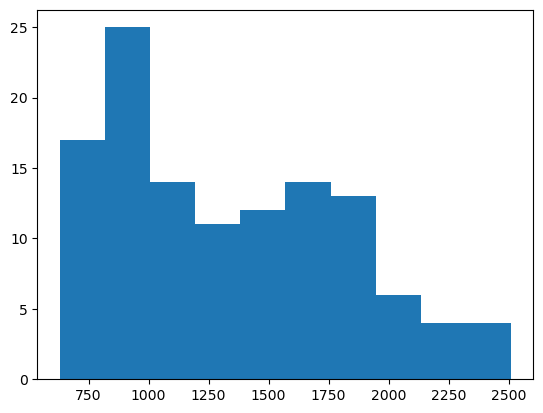

In [8]:
plt.hist(dialog_lens)
plt.show()

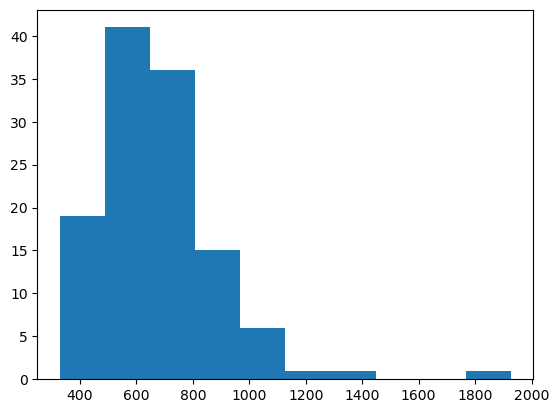

In [9]:
plt.hist(summary_lens)
plt.show()

In [10]:
from torch.utils.data import Dataset, DataLoader

class ClassifierDataset(Dataset):

    def __init__(self, data):
        super().__init__()

        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        sample = self.data[index]

        context = '\n\n'.join(['\n'.join([f'Fact about {sample["speaker"]}:', sample['fact']]),
                               sample['dialog'], ])
        
        target = sample['target']

        return context, target

In [11]:
class Collator:

    def __init__(self, tokenizer, max_length=2048):

        self.tokenizer = tokenizer

        self.max_length = max_length

    def __call__(self, batch):

        inputs = []
        targets = []

        for context, target in batch:
            inputs.append(context)
            targets.append(target)

        tokenized_input = self.tokenizer(
            inputs, 
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=self.max_length,
        )

        return tokenized_input, torch.LongTensor(targets)

In [12]:
from random import sample

BATCH_SIZE = 8

train_dataset = ClassifierDataset(data=dataset[:int(len(dataset)*.8)])
valid_dataset = ClassifierDataset(data=dataset[int(len(dataset)*.8):])

collator = Collator(tokenizer=tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collator, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collator, shuffle=True)

In [15]:
from tqdm import tqdm
import numpy as np

def loop(n_epoch, is_train, criterion, optimizer, model, loader, grad_acum_steps=1):
    
    global_step = len(loader) // grad_acum_steps * n_epoch


    all_predictions = list()
    all_targets = list()

    losses = list()
    f1_scores = list()
    accuracies = list()
    rocs = list()

    progress_bar = tqdm(total=len(loader) // grad_acum_steps, desc="Train" if is_train else "Valid")

    if is_train:
        model.train()
    else:
        model.eval()

    losses = list()

    for n_step, (batch, targets) in enumerate(loader):

        batch = batch.to(model.device)
        targets = targets.to(model.device)

        if is_train:
            optimizer.zero_grad()
            logits = model(batch, batch.attention_mask)
        else:
            with torch.no_grad():
                logits = model(batch, batch.attention_mask)

        loss = criterion(logits, targets)

        f1_scores.append(f1_score(targets.detach().cpu(), 
                                  logits.detach().cpu().argmax(1), 
                                  zero_division=False))
        accuracies.append(accuracy_score(targets.detach().cpu(), 
                                         logits.detach().cpu().argmax(1)))
        
        try:
            rocs.append(roc_auc_score(targets.detach().cpu(), 
                                      F.softmax(logits.detach().cpu(), dim=1)[:, 1]))
        except:
            rocs.append(0)
            pass
        
        losses.append(loss.item())

        if is_train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=0.7)
            optimizer.step()
        progress_bar.update()
        progress_bar.set_postfix(loss=np.mean(losses[-100:]), 
                                 f1_score=np.mean(f1_scores[-100:]),
                                 accuracy=np.mean(accuracies[-100:]), 
                                 roc_auc=np.mean(rocs[-100:]))

        global_step += 1


    progress_bar.close()

    return losses, f1_scores, accuracies, rocs

In [16]:
class ResidualLayer(nn.Module):
    
    def __init__(self, in_features, hidden_features):

        # Вызываем __init__ родителя - torch.nn.Module
        super().__init__()
        
        # определяем слои и все что захотим сохранять/использовать
        self.linear_1 = torch.nn.Linear(in_features=in_features, out_features=hidden_features)
        self.relu_1 = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=hidden_features, out_features=in_features)
        self.relu_2 = torch.nn.ReLU()

    def forward(self, x):
        residual = x.clone()
        
        x = self.relu_1(self.linear_1(x))
        x = self.relu_2(self.linear_2(x))

        x = x + residual

        return x

In [17]:
class Classifier(nn.Module):
    def __init__(self, lang_model, pooling, dropout, n_classes):
        super().__init__()
        self.lang_model = lang_model
        self.device = lang_model.device
        self.pooling = pooling
        self.batch_norm = nn.BatchNorm1d(lang_model.config.d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        # self.res_layer = ResidualLayer(lang_model.config.d_model, lang_model.config.d_model // 2)
        self.linear = nn.Linear(lang_model.config.d_model, n_classes)

    def forward(self, X, attention):
        X = self.lang_model(**X)
        X = self.pooling(X.last_hidden_state, attention)
        X = self.dropout(X)
        # X = self.batch_norm(X)
        # X = self.relu(X)
        # X = self.res_layer(X)
        X = self.linear(X)
        return X

In [18]:
import optuna
from optuna.trial import TrialState

def define_model(trial):
    pooling_type = "mean"
    dropout = trial.suggest_float("dropout", .1, .7)
    normalize = trial.suggest_int("normalize", False, True)
    embedding_masking = trial.suggest_int("embedding_masking", False, True)

    pooling = GlobalMaskedPooling(pooling_type=pooling_type, normalize=normalize, 
                                  embedding_masking=embedding_masking)
    classifier = Classifier(model, pooling, dropout, 2)
    return classifier

def get_dataset_loaders():
    train_dataset = ClassifierDataset(data=dataset[:int(len(dataset)*.8)])
    valid_dataset = ClassifierDataset(data=dataset[int(len(dataset)*.8):])

    collator = Collator(tokenizer=tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collator, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collator, shuffle=True)

    return train_loader, valid_loader

def objective(trial):
    model = define_model(trial).to('mps')

    lr = trial.suggest_float("lr", 1e-7, 1e-3, log=True)
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr)

    criterion = nn.CrossEntropyLoss()

    train_loader, valid_loader = get_dataset_loaders()

    # Training of the model.
    for epoch in range(5):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(model.device)
            target = target.to(model.device)

            optimizer.zero_grad()
            output = model(data, data.attention_mask)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        f1_scores = list()
        outputs = list()
        targets = list()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                data = data.to(model.device)
                target = target.to(model.device)

                output = model(data, data.attention_mask)
                # Get the index of the max log-probability.
                pred = output.detach().cpu().argmax(dim=1, keepdim=True)
                correct += pred.eq(target.detach().cpu().view_as(pred)).sum().item()
                
                outputs.extend(F.softmax(output.detach().cpu(), dim=1)[:, 1])
                targets.extend(target.detach().cpu())

        accuracy = correct / len(valid_loader.dataset)
        # f1 = f1_score(targets, outputs)
        roc_auc = 0
        try:
            roc_auc = roc_auc_score(targets, outputs)
        except Exception as e:
            print(e)
            pass

        trial.report(roc_auc, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return roc_auc

In [19]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5, timeout=6000)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
trial.params

[I 2023-05-03 13:12:04,664] A new study created in memory with name: no-name-0253ab93-574d-4dde-9fce-fb7e2ba65708
[I 2023-05-03 13:27:39,219] Trial 0 finished with value: 0.551769406392694 and parameters: {'dropout': 0.2694027612062093, 'normalize': 1, 'embedding_masking': 1, 'lr': 2.0697744904162145e-05}. Best is trial 0 with value: 0.551769406392694.
[I 2023-05-03 13:40:52,666] Trial 1 finished with value: 0.49556697108066966 and parameters: {'dropout': 0.21286946415114094, 'normalize': 1, 'embedding_masking': 1, 'lr': 3.0326046277227664e-07}. Best is trial 0 with value: 0.551769406392694.
[I 2023-05-03 13:53:22,706] Trial 2 finished with value: 0.5087328767123288 and parameters: {'dropout': 0.5627414317090125, 'normalize': 1, 'embedding_masking': 1, 'lr': 0.00010652828200157199}. Best is trial 0 with value: 0.551769406392694.
[I 2023-05-03 14:05:39,429] Trial 3 finished with value: 0.529337899543379 and parameters: {'dropout': 0.4502246220906928, 'normalize': 0, 'embedding_masking':

Study statistics: 
  Number of finished trials:  5
  Number of pruned trials:  0
  Number of complete trials:  5
Best trial:
  Value:  0.551769406392694
  Params: 


{'dropout': 0.2694027612062093,
 'normalize': 1,
 'embedding_masking': 1,
 'lr': 2.0697744904162145e-05}

In [20]:
params = {'dropout': 0.2694027612062093,
 'normalize': 1,
 'embedding_masking': 1,
 'lr': 2.0697744904162145e-05}

pooling = GlobalMaskedPooling(normalize=params['normalize'], 
                              embedding_masking=params['embedding_masking'])
classifier = Classifier(model, pooling, params['dropout'], 2).to(device)

In [21]:
criterion = nn.CrossEntropyLoss()


optimizer = torch.optim.AdamW(params=classifier.parameters(), lr=params['lr'])

In [22]:
from tqdm import tqdm

best_valid_loss = np.inf
losses = []
f1_scores = []
accuracies = []
rocs = []

for n_epoch in range(100):

    train_losses, train_f1_scores, train_accuracies, train_roc_auc = loop(n_epoch, True, 
                                                                          criterion,
                                                                          optimizer, classifier, 
                                                                          loader=train_loader)
    valid_losses, valid_f1_scores, valid_accuracies, valid_roc_auc = loop(n_epoch, False,
                                                                          criterion,
                                                                          optimizer, classifier,
                                                                          loader=valid_loader)

    train_mean_loss = np.mean(train_losses)
    valid_mean_loss = np.mean(valid_losses)

    train_mean_f1_scores = np.mean(train_f1_scores)
    valid_mean_f1_scores = np.mean(valid_f1_scores)

    train_mean_accuracies = np.mean(train_accuracies)
    valid_mean_accuracies = np.mean(valid_accuracies)
    
    train_mean_roc_auc = np.mean(train_roc_auc)
    valid_mean_roc_auc = np.mean(valid_roc_auc)
    
    losses.append(valid_mean_loss)
    f1_scores.append(valid_mean_f1_scores)
    accuracies.append(valid_mean_accuracies)
    rocs.append(valid_mean_roc_auc)

    epoch_message = [
        f"Epoch {n_epoch} done",
        "",
        "Train",
        f"\tLoss: {train_mean_loss:.3f}",
        f"\tF1-score: {train_mean_f1_scores:.3f}",
        f"\tAccuracy: {train_mean_accuracies:.3f}",
        f"\tROC AUC: {train_mean_roc_auc:.3f}",
        "Valid",
        f"\tLoss: {valid_mean_loss:.3f}",
        f"\tF1-score: {valid_mean_f1_scores:.3f}",
        f"\tAccuracy: {valid_mean_accuracies:.3f}",
        f"\tROC AUC: {valid_mean_roc_auc:.3f}",
    ]

    print("\n".join(epoch_message))
    
    if valid_mean_loss > np.mean(losses) or np.isnan(np.mean(losses)):
        print('early stop')
        break

    if valid_mean_loss < best_valid_loss:
        best_valid_loss = valid_mean_loss
        torch.save(classifier, "best_classifier.pth")
        
torch.save(classifier, "last_classifier.pth")

Valid: 100%|██████████| 43/43 [00:32<00:00,  1.31it/s, accuracy=0.641, f1_score=0.769, loss=0.687, roc_auc=0.462]


Epoch 0 done

Train
	Loss: 0.691
	F1-score: 0.636
	Accuracy: 0.558
	ROC AUC: 0.499
Valid
	Loss: 0.687
	F1-score: 0.769
	Accuracy: 0.641
	ROC AUC: 0.462


Valid: 100%|██████████| 43/43 [00:23<00:00,  1.82it/s, accuracy=0.651, f1_score=0.776, loss=0.679, roc_auc=0.429]


Epoch 1 done

Train
	Loss: 0.683
	F1-score: 0.769
	Accuracy: 0.643
	ROC AUC: 0.466
Valid
	Loss: 0.679
	F1-score: 0.776
	Accuracy: 0.651
	ROC AUC: 0.429


Valid: 100%|██████████| 43/43 [00:23<00:00,  1.81it/s, accuracy=0.651, f1_score=0.777, loss=0.673, roc_auc=0.43] 


Epoch 2 done

Train
	Loss: 0.676
	F1-score: 0.769
	Accuracy: 0.643
	ROC AUC: 0.491
Valid
	Loss: 0.673
	F1-score: 0.777
	Accuracy: 0.651
	ROC AUC: 0.430


Valid: 100%|██████████| 43/43 [00:23<00:00,  1.87it/s, accuracy=0.646, f1_score=0.77, loss=0.668, roc_auc=0.437] 


Epoch 3 done

Train
	Loss: 0.672
	F1-score: 0.769
	Accuracy: 0.641
	ROC AUC: 0.479
Valid
	Loss: 0.668
	F1-score: 0.770
	Accuracy: 0.646
	ROC AUC: 0.437


Valid: 100%|██████████| 43/43 [00:25<00:00,  1.70it/s, accuracy=0.646, f1_score=0.776, loss=0.665, roc_auc=0.461]


Epoch 4 done

Train
	Loss: 0.667
	F1-score: 0.770
	Accuracy: 0.646
	ROC AUC: 0.463
Valid
	Loss: 0.665
	F1-score: 0.776
	Accuracy: 0.646
	ROC AUC: 0.461


Valid: 100%|██████████| 43/43 [00:23<00:00,  1.86it/s, accuracy=0.641, f1_score=0.77, loss=0.663, roc_auc=0.458] 


Epoch 5 done

Train
	Loss: 0.663
	F1-score: 0.768
	Accuracy: 0.646
	ROC AUC: 0.449
Valid
	Loss: 0.663
	F1-score: 0.770
	Accuracy: 0.641
	ROC AUC: 0.458


Valid: 100%|██████████| 43/43 [00:22<00:00,  1.88it/s, accuracy=0.646, f1_score=0.769, loss=0.659, roc_auc=0.441]


Epoch 6 done

Train
	Loss: 0.660
	F1-score: 0.770
	Accuracy: 0.646
	ROC AUC: 0.489
Valid
	Loss: 0.659
	F1-score: 0.769
	Accuracy: 0.646
	ROC AUC: 0.441


Valid: 100%|██████████| 43/43 [00:21<00:00,  2.01it/s, accuracy=0.641, f1_score=0.767, loss=0.659, roc_auc=0.458]


Epoch 7 done

Train
	Loss: 0.658
	F1-score: 0.770
	Accuracy: 0.646
	ROC AUC: 0.478
Valid
	Loss: 0.659
	F1-score: 0.767
	Accuracy: 0.641
	ROC AUC: 0.458


Valid: 100%|██████████| 43/43 [00:22<00:00,  1.88it/s, accuracy=0.641, f1_score=0.763, loss=0.657, roc_auc=0.455]


Epoch 8 done

Train
	Loss: 0.656
	F1-score: 0.771
	Accuracy: 0.646
	ROC AUC: 0.519
Valid
	Loss: 0.657
	F1-score: 0.763
	Accuracy: 0.641
	ROC AUC: 0.455


Valid: 100%|██████████| 43/43 [00:25<00:00,  1.66it/s, accuracy=0.646, f1_score=0.773, loss=0.654, roc_auc=0.441]


Epoch 9 done

Train
	Loss: 0.654
	F1-score: 0.771
	Accuracy: 0.646
	ROC AUC: 0.509
Valid
	Loss: 0.654
	F1-score: 0.773
	Accuracy: 0.646
	ROC AUC: 0.441


Valid: 100%|██████████| 43/43 [00:21<00:00,  2.03it/s, accuracy=0.646, f1_score=0.771, loss=0.654, roc_auc=0.472]


Epoch 10 done

Train
	Loss: 0.655
	F1-score: 0.769
	Accuracy: 0.641
	ROC AUC: 0.526
Valid
	Loss: 0.654
	F1-score: 0.771
	Accuracy: 0.646
	ROC AUC: 0.472


Valid: 100%|██████████| 43/43 [00:21<00:00,  1.98it/s, accuracy=0.646, f1_score=0.778, loss=0.653, roc_auc=0.49] 


Epoch 11 done

Train
	Loss: 0.654
	F1-score: 0.771
	Accuracy: 0.643
	ROC AUC: 0.521
Valid
	Loss: 0.653
	F1-score: 0.778
	Accuracy: 0.646
	ROC AUC: 0.490


Valid: 100%|██████████| 43/43 [00:22<00:00,  1.87it/s, accuracy=0.646, f1_score=0.769, loss=0.652, roc_auc=0.445]


Epoch 12 done

Train
	Loss: 0.654
	F1-score: 0.765
	Accuracy: 0.641
	ROC AUC: 0.500
Valid
	Loss: 0.652
	F1-score: 0.769
	Accuracy: 0.646
	ROC AUC: 0.445


Valid: 100%|██████████| 43/43 [00:23<00:00,  1.83it/s, accuracy=0.651, f1_score=0.778, loss=0.649, roc_auc=0.466]


Epoch 13 done

Train
	Loss: 0.652
	F1-score: 0.768
	Accuracy: 0.643
	ROC AUC: 0.530
Valid
	Loss: 0.649
	F1-score: 0.778
	Accuracy: 0.651
	ROC AUC: 0.466


Valid: 100%|██████████| 43/43 [00:26<00:00,  1.64it/s, accuracy=0.646, f1_score=0.773, loss=0.651, roc_auc=0.469]


Epoch 14 done

Train
	Loss: 0.652
	F1-score: 0.770
	Accuracy: 0.643
	ROC AUC: 0.516
Valid
	Loss: 0.651
	F1-score: 0.773
	Accuracy: 0.646
	ROC AUC: 0.469


Valid: 100%|██████████| 43/43 [00:23<00:00,  1.84it/s, accuracy=0.646, f1_score=0.772, loss=0.651, roc_auc=0.47] 


Epoch 15 done

Train
	Loss: 0.650
	F1-score: 0.771
	Accuracy: 0.646
	ROC AUC: 0.520
Valid
	Loss: 0.651
	F1-score: 0.772
	Accuracy: 0.646
	ROC AUC: 0.470


Valid: 100%|██████████| 43/43 [00:21<00:00,  2.04it/s, accuracy=0.646, f1_score=0.776, loss=0.651, roc_auc=0.519]


Epoch 16 done

Train
	Loss: 0.650
	F1-score: 0.771
	Accuracy: 0.646
	ROC AUC: 0.529
Valid
	Loss: 0.651
	F1-score: 0.776
	Accuracy: 0.646
	ROC AUC: 0.519


Valid: 100%|██████████| 43/43 [00:23<00:00,  1.85it/s, accuracy=0.641, f1_score=0.764, loss=0.653, roc_auc=0.479]


Epoch 17 done

Train
	Loss: 0.650
	F1-score: 0.772
	Accuracy: 0.646
	ROC AUC: 0.541
Valid
	Loss: 0.653
	F1-score: 0.764
	Accuracy: 0.641
	ROC AUC: 0.479


Valid: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s, accuracy=0.641, f1_score=0.767, loss=0.653, roc_auc=0.45] 


Epoch 18 done

Train
	Loss: 0.650
	F1-score: 0.773
	Accuracy: 0.646
	ROC AUC: 0.524
Valid
	Loss: 0.653
	F1-score: 0.767
	Accuracy: 0.641
	ROC AUC: 0.450


Valid: 100%|██████████| 43/43 [00:23<00:00,  1.86it/s, accuracy=0.646, f1_score=0.77, loss=0.65, roc_auc=0.473]  


Epoch 19 done

Train
	Loss: 0.649
	F1-score: 0.772
	Accuracy: 0.646
	ROC AUC: 0.537
Valid
	Loss: 0.650
	F1-score: 0.770
	Accuracy: 0.646
	ROC AUC: 0.473


Valid: 100%|██████████| 43/43 [00:22<00:00,  1.88it/s, accuracy=0.651, f1_score=0.768, loss=0.647, roc_auc=0.434]


Epoch 20 done

Train
	Loss: 0.651
	F1-score: 0.770
	Accuracy: 0.643
	ROC AUC: 0.528
Valid
	Loss: 0.647
	F1-score: 0.768
	Accuracy: 0.651
	ROC AUC: 0.434


Valid: 100%|██████████| 43/43 [00:23<00:00,  1.85it/s, accuracy=0.641, f1_score=0.769, loss=0.653, roc_auc=0.514]


Epoch 21 done

Train
	Loss: 0.652
	F1-score: 0.765
	Accuracy: 0.641
	ROC AUC: 0.526
Valid
	Loss: 0.653
	F1-score: 0.769
	Accuracy: 0.641
	ROC AUC: 0.514


Valid: 100%|██████████| 43/43 [00:22<00:00,  1.93it/s, accuracy=0.646, f1_score=0.777, loss=0.65, roc_auc=0.475] 


Epoch 22 done

Train
	Loss: 0.650
	F1-score: 0.769
	Accuracy: 0.643
	ROC AUC: 0.538
Valid
	Loss: 0.650
	F1-score: 0.777
	Accuracy: 0.646
	ROC AUC: 0.475


Valid: 100%|██████████| 43/43 [00:22<00:00,  1.95it/s, accuracy=0.646, f1_score=0.774, loss=0.65, roc_auc=0.521] 


Epoch 23 done

Train
	Loss: 0.648
	F1-score: 0.771
	Accuracy: 0.646
	ROC AUC: 0.577
Valid
	Loss: 0.650
	F1-score: 0.774
	Accuracy: 0.646
	ROC AUC: 0.521


Valid: 100%|██████████| 43/43 [00:22<00:00,  1.95it/s, accuracy=0.641, f1_score=0.769, loss=0.653, roc_auc=0.49] 


Epoch 24 done

Train
	Loss: 0.649
	F1-score: 0.770
	Accuracy: 0.646
	ROC AUC: 0.530
Valid
	Loss: 0.653
	F1-score: 0.769
	Accuracy: 0.641
	ROC AUC: 0.490


Valid: 100%|██████████| 43/43 [00:27<00:00,  1.55it/s, accuracy=0.637, f1_score=0.755, loss=0.656, roc_auc=0.451]


Epoch 25 done

Train
	Loss: 0.649
	F1-score: 0.772
	Accuracy: 0.646
	ROC AUC: 0.508
Valid
	Loss: 0.656
	F1-score: 0.755
	Accuracy: 0.637
	ROC AUC: 0.451


Valid: 100%|██████████| 43/43 [00:21<00:00,  1.96it/s, accuracy=0.646, f1_score=0.773, loss=0.65, roc_auc=0.495] 


Epoch 26 done

Train
	Loss: 0.649
	F1-score: 0.771
	Accuracy: 0.646
	ROC AUC: 0.539
Valid
	Loss: 0.650
	F1-score: 0.773
	Accuracy: 0.646
	ROC AUC: 0.495


Valid: 100%|██████████| 43/43 [00:23<00:00,  1.84it/s, accuracy=0.646, f1_score=0.769, loss=0.65, roc_auc=0.494] 


Epoch 27 done

Train
	Loss: 0.649
	F1-score: 0.772
	Accuracy: 0.646
	ROC AUC: 0.507
Valid
	Loss: 0.650
	F1-score: 0.769
	Accuracy: 0.646
	ROC AUC: 0.494


Valid: 100%|██████████| 43/43 [00:23<00:00,  1.83it/s, accuracy=0.641, f1_score=0.765, loss=0.652, roc_auc=0.516]


Epoch 28 done

Train
	Loss: 0.650
	F1-score: 0.769
	Accuracy: 0.643
	ROC AUC: 0.563
Valid
	Loss: 0.652
	F1-score: 0.765
	Accuracy: 0.641
	ROC AUC: 0.516


Valid: 100%|██████████| 43/43 [00:21<00:00,  2.03it/s, accuracy=0.641, f1_score=0.765, loss=0.653, roc_auc=0.455]


Epoch 29 done

Train
	Loss: 0.650
	F1-score: 0.770
	Accuracy: 0.643
	ROC AUC: 0.552
Valid
	Loss: 0.653
	F1-score: 0.765
	Accuracy: 0.641
	ROC AUC: 0.455


Valid: 100%|██████████| 43/43 [00:24<00:00,  1.73it/s, accuracy=0.646, f1_score=0.774, loss=0.65, roc_auc=0.502] 


Epoch 30 done

Train
	Loss: 0.649
	F1-score: 0.773
	Accuracy: 0.646
	ROC AUC: 0.525
Valid
	Loss: 0.650
	F1-score: 0.774
	Accuracy: 0.646
	ROC AUC: 0.502


Valid: 100%|██████████| 43/43 [00:22<00:00,  1.91it/s, accuracy=0.651, f1_score=0.774, loss=0.647, roc_auc=0.482]


Epoch 31 done

Train
	Loss: 0.650
	F1-score: 0.770
	Accuracy: 0.643
	ROC AUC: 0.552
Valid
	Loss: 0.647
	F1-score: 0.774
	Accuracy: 0.651
	ROC AUC: 0.482


Valid: 100%|██████████| 43/43 [00:26<00:00,  1.65it/s, accuracy=0.651, f1_score=0.773, loss=0.647, roc_auc=0.515]


Epoch 32 done

Train
	Loss: 0.649
	F1-score: 0.774
	Accuracy: 0.646
	ROC AUC: 0.531
Valid
	Loss: 0.647
	F1-score: 0.773
	Accuracy: 0.651
	ROC AUC: 0.515


Valid: 100%|██████████| 43/43 [00:23<00:00,  1.82it/s, accuracy=0.651, f1_score=0.779, loss=0.647, roc_auc=0.534]


Epoch 33 done

Train
	Loss: 0.648
	F1-score: 0.772
	Accuracy: 0.646
	ROC AUC: 0.537
Valid
	Loss: 0.647
	F1-score: 0.779
	Accuracy: 0.651
	ROC AUC: 0.534


Valid: 100%|██████████| 43/43 [00:21<00:00,  2.02it/s, accuracy=0.646, f1_score=0.773, loss=0.649, roc_auc=0.55] 


Epoch 34 done

Train
	Loss: 0.651
	F1-score: 0.766
	Accuracy: 0.641
	ROC AUC: 0.523
Valid
	Loss: 0.649
	F1-score: 0.773
	Accuracy: 0.646
	ROC AUC: 0.550


Valid: 100%|██████████| 43/43 [00:21<00:00,  2.02it/s, accuracy=0.646, f1_score=0.776, loss=0.65, roc_auc=0.503] 


Epoch 35 done

Train
	Loss: 0.650
	F1-score: 0.766
	Accuracy: 0.643
	ROC AUC: 0.521
Valid
	Loss: 0.650
	F1-score: 0.776
	Accuracy: 0.646
	ROC AUC: 0.503


Valid: 100%|██████████| 43/43 [00:21<00:00,  1.98it/s, accuracy=0.646, f1_score=0.77, loss=0.65, roc_auc=0.504]  


Epoch 36 done

Train
	Loss: 0.649
	F1-score: 0.770
	Accuracy: 0.643
	ROC AUC: 0.566
Valid
	Loss: 0.650
	F1-score: 0.770
	Accuracy: 0.646
	ROC AUC: 0.504


Valid: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s, accuracy=0.646, f1_score=0.77, loss=0.649, roc_auc=0.515] 


Epoch 37 done

Train
	Loss: 0.648
	F1-score: 0.771
	Accuracy: 0.646
	ROC AUC: 0.550
Valid
	Loss: 0.649
	F1-score: 0.770
	Accuracy: 0.646
	ROC AUC: 0.515


Valid: 100%|██████████| 43/43 [00:26<00:00,  1.60it/s, accuracy=0.646, f1_score=0.773, loss=0.649, roc_auc=0.502]


Epoch 38 done

Train
	Loss: 0.649
	F1-score: 0.771
	Accuracy: 0.643
	ROC AUC: 0.555
Valid
	Loss: 0.649
	F1-score: 0.773
	Accuracy: 0.646
	ROC AUC: 0.502


Valid: 100%|██████████| 43/43 [00:23<00:00,  1.82it/s, accuracy=0.651, f1_score=0.778, loss=0.646, roc_auc=0.473]


Epoch 39 done

Train
	Loss: 0.647
	F1-score: 0.772
	Accuracy: 0.646
	ROC AUC: 0.557
Valid
	Loss: 0.646
	F1-score: 0.778
	Accuracy: 0.651
	ROC AUC: 0.473


Valid: 100%|██████████| 43/43 [00:21<00:00,  2.03it/s, accuracy=0.646, f1_score=0.77, loss=0.65, roc_auc=0.477]  


Epoch 40 done

Train
	Loss: 0.648
	F1-score: 0.771
	Accuracy: 0.646
	ROC AUC: 0.526
Valid
	Loss: 0.650
	F1-score: 0.770
	Accuracy: 0.646
	ROC AUC: 0.477


Valid: 100%|██████████| 43/43 [00:23<00:00,  1.84it/s, accuracy=0.641, f1_score=0.772, loss=0.653, roc_auc=0.463]


Epoch 41 done

Train
	Loss: 0.650
	F1-score: 0.770
	Accuracy: 0.643
	ROC AUC: 0.564
Valid
	Loss: 0.653
	F1-score: 0.772
	Accuracy: 0.641
	ROC AUC: 0.463


Valid: 100%|██████████| 43/43 [00:22<00:00,  1.92it/s, accuracy=0.651, f1_score=0.776, loss=0.646, roc_auc=0.505]


Epoch 42 done

Train
	Loss: 0.648
	F1-score: 0.772
	Accuracy: 0.646
	ROC AUC: 0.545
Valid
	Loss: 0.646
	F1-score: 0.776
	Accuracy: 0.651
	ROC AUC: 0.505


Valid: 100%|██████████| 43/43 [00:21<00:00,  1.99it/s, accuracy=0.646, f1_score=0.775, loss=0.649, roc_auc=0.505]


Epoch 43 done

Train
	Loss: 0.650
	F1-score: 0.768
	Accuracy: 0.641
	ROC AUC: 0.536
Valid
	Loss: 0.649
	F1-score: 0.775
	Accuracy: 0.646
	ROC AUC: 0.505


Valid: 100%|██████████| 43/43 [00:21<00:00,  2.02it/s, accuracy=0.641, f1_score=0.769, loss=0.652, roc_auc=0.538]


Epoch 44 done

Train
	Loss: 0.649
	F1-score: 0.770
	Accuracy: 0.643
	ROC AUC: 0.565
Valid
	Loss: 0.652
	F1-score: 0.769
	Accuracy: 0.641
	ROC AUC: 0.538


Valid: 100%|██████████| 43/43 [00:20<00:00,  2.08it/s, accuracy=0.646, f1_score=0.773, loss=0.649, roc_auc=0.548]


Epoch 45 done

Train
	Loss: 0.647
	F1-score: 0.770
	Accuracy: 0.646
	ROC AUC: 0.550
Valid
	Loss: 0.649
	F1-score: 0.773
	Accuracy: 0.646
	ROC AUC: 0.548


Valid: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s, accuracy=0.646, f1_score=0.777, loss=0.649, roc_auc=0.547]


Epoch 46 done

Train
	Loss: 0.650
	F1-score: 0.766
	Accuracy: 0.641
	ROC AUC: 0.566
Valid
	Loss: 0.649
	F1-score: 0.777
	Accuracy: 0.646
	ROC AUC: 0.547


Valid: 100%|██████████| 43/43 [00:21<00:00,  2.00it/s, accuracy=0.646, f1_score=0.772, loss=0.649, roc_auc=0.508]


Epoch 47 done

Train
	Loss: 0.648
	F1-score: 0.773
	Accuracy: 0.643
	ROC AUC: 0.585
Valid
	Loss: 0.649
	F1-score: 0.772
	Accuracy: 0.646
	ROC AUC: 0.508


Valid: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s, accuracy=0.641, f1_score=0.771, loss=0.652, roc_auc=0.498]


Epoch 48 done

Train
	Loss: 0.648
	F1-score: 0.769
	Accuracy: 0.646
	ROC AUC: 0.555
Valid
	Loss: 0.652
	F1-score: 0.771
	Accuracy: 0.641
	ROC AUC: 0.498


Valid: 100%|██████████| 43/43 [00:23<00:00,  1.83it/s, accuracy=0.641, f1_score=0.77, loss=0.652, roc_auc=0.505] 


Epoch 49 done

Train
	Loss: 0.648
	F1-score: 0.771
	Accuracy: 0.643
	ROC AUC: 0.584
Valid
	Loss: 0.652
	F1-score: 0.770
	Accuracy: 0.641
	ROC AUC: 0.505


Valid: 100%|██████████| 43/43 [00:23<00:00,  1.80it/s, accuracy=0.637, f1_score=0.762, loss=0.655, roc_auc=0.534]


Epoch 50 done

Train
	Loss: 0.650
	F1-score: 0.766
	Accuracy: 0.641
	ROC AUC: 0.544
Valid
	Loss: 0.655
	F1-score: 0.762
	Accuracy: 0.637
	ROC AUC: 0.534
early stop


In [24]:
np.mean(losses), best_valid_loss, valid_mean_loss

(0.6536384532699507, 0.6463814634223317, 0.6550496678019679)

In [25]:
classifier = torch.load('best_classifier.pth')

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision 

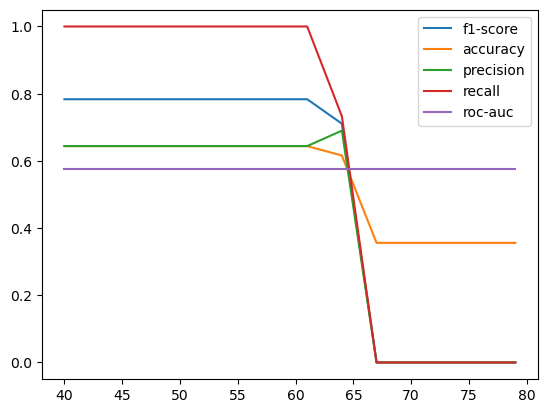

In [51]:
step_threshold = 3
min_threshold, max_threshold = 40, 80

f1_results = []
accuracies = []
precisions = []
recalls = []
roc_aucs = []

thresholds_range = range(min_threshold, max_threshold, step_threshold)

classifier.eval()

y_hats = []
y_true = []
for n_step, (batch, targets) in enumerate(train_loader):

    batch = batch.to(classifier.device)

    with torch.no_grad():
        logits = classifier(batch, batch.attention_mask)

    outputs = F.softmax(logits.detach().cpu(), dim=1)[:, 1]
    
    y_hats.extend(outputs.tolist())
    y_true.extend(targets.tolist())

for i in thresholds_range:
    thresholded_y_hats = np.array(y_hats) > i / 100
    f1_results.append(f1_score(y_true, thresholded_y_hats))
    accuracies.append(accuracy_score(y_true, thresholded_y_hats))
    precisions.append(precision_score(y_true, thresholded_y_hats))
    recalls.append(recall_score(y_true, thresholded_y_hats))
    roc_aucs.append(roc_auc_score(y_true, y_hats))
    
plt.plot(thresholds_range, f1_results, label='f1-score')
plt.plot(thresholds_range, accuracies, label='accuracy')
plt.plot(thresholds_range, precisions, label='precision')
plt.plot(thresholds_range, recalls, label='recall')
plt.plot(thresholds_range, roc_aucs, label='roc-auc')

plt.legend()
plt.show()

In [45]:
from random import sample

samples = sample(dataset[-50:], 10)
processed_samples = ['\n\n'.join(['\n'.join([f'Fact about {random_sample["speaker"]}:', 
                                          random_sample['fact']]), 
                                  random_sample['dialog'],]) for random_sample in samples]

In [46]:
print(processed_samples[0])

Fact about bot_1:
bot_1 is confident in their abilities to write a fantasy novel

bot_0: I heard on the news the other day that there may be some change in the for-profit education business. Some government officials are discussing tuition regulation, the article may interest you.
bot_1: Oh! I would love to read that. Can you give me a summary of what the article mentioned?
bot_0: It basically stated that high tuition is making it harder for some students to obtain a degree which could damage many industries in the future! I'm hopeful something is done, but you know how lax the government can be when it comes to that type of stuff.
bot_1: You're right. They are really slow to step in when it comes to the money side of education. Tuition has really grown out of control. There is no reason we should have debt before we've even entered the workforce.
bot_0: I agree completely. I don't know that it should be completely cost free, but definitely more affordable for sure. What about you, hav

In [47]:
inputs = tokenizer(
            processed_samples, 
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=2048,
        ).to(classifier.device)
with torch.no_grad():
    outputs = classifier(inputs, inputs.attention_mask)

In [48]:
F.softmax(outputs.detach().cpu(), dim=1)[:, 1]

tensor([0.6351, 0.6573, 0.6565, 0.6376, 0.6350, 0.6341, 0.6364, 0.6359, 0.6569,
        0.6576])

In [49]:
[int(random_sample['target']) for random_sample in samples]

[1, 1, 1, 1, 0, 1, 1, 0, 0, 1]

In [50]:
roc_auc_score([int(random_sample['target']) for random_sample in samples], F.softmax(outputs.detach().cpu(), dim=1)[:, 1])

0.6190476190476191

In [ ]:
100 - (100 * .1) * 1

90.0

In [ ]:
100 / 1

100.0